In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
import skimage
from keras import layers, models, utils
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, AveragePooling2D, Flatten, Dense, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.datasets import fashion_mnist


In [34]:
num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = np.array([skimage.transform.resize(image, (28, 28)) for image in np.expand_dims(x_train, -1)])[:10000]
x_test = np.array([skimage.transform.resize(image, (28, 28)) for image in np.expand_dims(x_test, -1)])
y_train = y_train.astype('int')[:10000]
y_test = y_test.astype('int')


# (x_train, y_train), (x_val, y_val) = fashion_mnist.load_data()
# x_train = x_train / 255.0
# x_val = x_val / 255.0
# y_train = keras.utils.to_categorical(y_train, 10)
# y_val = keras.utils.to_categorical(y_val, 10)


In [5]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [942, 1027, 1016, 1019, 974, 989, 1021, 1022, 990, 1000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [38]:
from keras.layers import Input, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Dense, Flatten, MaxPooling2D
from keras.models import Model
from keras.initializers import he_normal
from keras.regularizers import l2

def residual_block(inputs, filters, stride):
    shortcut = inputs
    
    x = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(filters * 4, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    if stride != 1 or inputs.shape[-1] != filters * 4:
        shortcut = Conv2D(filters * 4, kernel_size=1, strides=stride, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = ReLU()(x)
    
    return x

def ResNeXt50(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # Residual blocks
    x = residual_block(x, 64, 1)
    for _ in range(2):
        x = residual_block(x, 64, 1)
    
    x = residual_block(x, 128, 2)
    for _ in range(3):
        x = residual_block(x, 128, 1)
    
    x = residual_block(x, 256, 2)
    for _ in range(5):
        x = residual_block(x, 256, 1)
    
    x = residual_block(x, 512, 2)
    for _ in range(2):
        x = residual_block(x, 512, 1)

    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(units=num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x, name='ResNeXt50')
    return model


In [39]:
model = ResNeXt50(input_shape=(28, 28, 1), num_classes=10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [40]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-6)
]

history = model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=10,
    validation_split=0.2,
    callbacks=callbacks
)


Epoch 1/10
375/375 [==============================] - 44s 54ms/step - loss: 1.5114 - accuracy: 0.8071 - val_loss: 1.5099 - val_accuracy: 0.7829 - lr: 0.0010
Epoch 2/10
375/375 [==============================] - 19s 50ms/step - loss: 1.1738 - accuracy: 0.8759 - val_loss: 1.2557 - val_accuracy: 0.8428 - lr: 0.0010
Epoch 3/10
375/375 [==============================] - 18s 49ms/step - loss: 1.0047 - accuracy: 0.8942 - val_loss: 1.0317 - val_accuracy: 0.8648 - lr: 0.0010
Epoch 4/10
375/375 [==============================] - 18s 49ms/step - loss: 0.8613 - accuracy: 0.9032 - val_loss: 0.9780 - val_accuracy: 0.8547 - lr: 0.0010
Epoch 5/10
375/375 [==============================] - 18s 49ms/step - loss: 0.7397 - accuracy: 0.9109 - val_loss: 0.9689 - val_accuracy: 0.8311 - lr: 0.0010
Epoch 6/10
375/375 [==============================] - 18s 49ms/step - loss: 0.6341 - accuracy: 0.9171 - val_loss: 0.9604 - val_accuracy: 0.8166 - lr: 0.0010
Epoch 7/10
375/375 [==============================] - 20s 

In [41]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

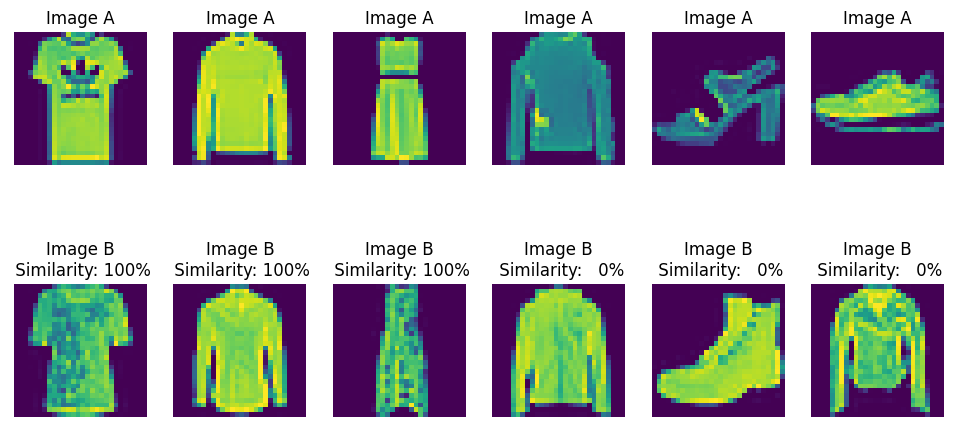

In [78]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
  ax1.imshow(c_a[:,:,0])
  ax1.set_title('Image A')
  ax1.axis('off')
  ax2.imshow(c_b[:,:,0])
  ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
  ax2.axis('off')

In [80]:
from keras.layers import concatenate


img_a_in = layers.Input(shape=x_train.shape[1:], name="ImageA_Input")
img_b_in = layers.Input(shape=x_train.shape[1:], name="ImageB_Input")
img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)
combined_features = layers.concatenate([img_a_feat, img_b_feat], name="merge_features")
combined_features = layers.Dense(256, activation="linear")(combined_features)
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation("relu")(combined_features)
combined_features = layers.Dense(128, activation="linear")(combined_features)
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation("relu")(combined_features)
combined_features = layers.Dense(1, activation="sigmoid")(combined_features)
similarity_model = models.Model(
    inputs=[img_a_in, img_b_in], outputs=[combined_features], name="SimilarityModel"
)
similarity_model.summary()
     

Model: "SimilarityModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28)]     0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28)]     0           []                               
                                                                                                  
 FeatureExtractor (Functional)  (None, 512)          22750080    ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 1024)         0           ['FeatureExtractor[

In [81]:
similarity_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["mae"])

In [86]:

def show_model_output(nb_examples=3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:, :, 0])
        ax1.set_title("Image A\n Actual: %3.0f%%" % (100 * c_d))
        ax1.axis("off")
        ax2.imshow(c_b[:, :, 0])
        ax2.set_title("Image B\n Predicted: %3.0f%%" % (100 * p_d))
        ax2.axis("off")
    return fig

1/1 [==============================] - 0s 33ms/step


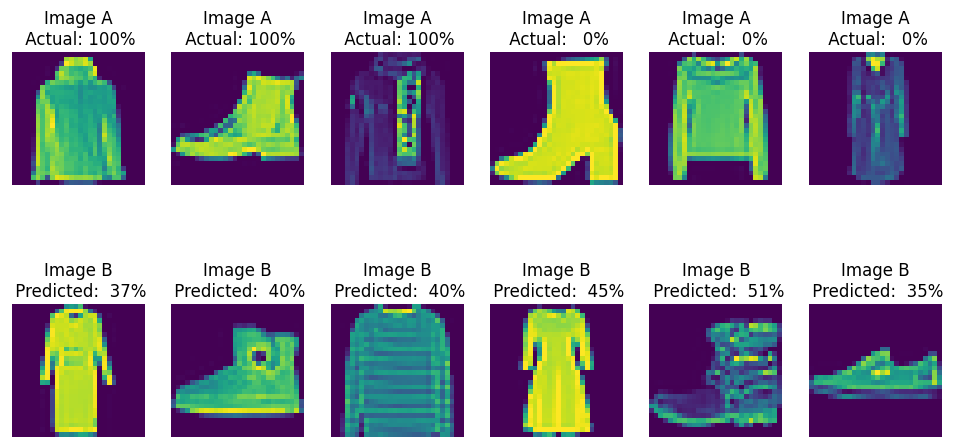

In [87]:
_ = show_model_output()

In [89]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
  while True:
    pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
    yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for modelperformance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(siam_gen(train_groups),
                                              steps_per_epoch = 500,
                                              validation_data=([valid_a, valid_b],
                                              valid_sim),
                                              epochs = 10,
                                              verbose = True)

Epoch 1/10


<ipython-input-89-59951d259804>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = similarity_model.fit_generator(siam_gen(train_groups),


500/500 [==============================] - 63s 73ms/step - loss: 0.5748 - mae: 0.2237 - val_loss: 0.5350 - val_mae: 0.2206
Epoch 2/10
500/500 [==============================] - 33s 67ms/step - loss: 0.4836 - mae: 0.1746 - val_loss: 0.5882 - val_mae: 0.2232
Epoch 3/10
500/500 [==============================] - 34s 68ms/step - loss: 0.4537 - mae: 0.1570 - val_loss: 0.7098 - val_mae: 0.2462
Epoch 4/10
500/500 [==============================] - 34s 68ms/step - loss: 0.4232 - mae: 0.1484 - val_loss: 0.7078 - val_mae: 0.2582
Epoch 5/10
500/500 [==============================] - 34s 68ms/step - loss: 0.4063 - mae: 0.1397 - val_loss: 0.5621 - val_mae: 0.1751
Epoch 6/10
500/500 [==============================] - 34s 69ms/step - loss: 0.3975 - mae: 0.1351 - val_loss: 0.4336 - val_mae: 0.1507
Epoch 7/10
500/500 [==============================] - 35s 69ms/step - loss: 0.3714 - mae: 0.1268 - val_loss: 0.3954 - val_mae: 0.1344
Epoch 8/10
500/500 [==============================] - 35s 69ms/step - los

1/1 [==============================] - 0s 40ms/step


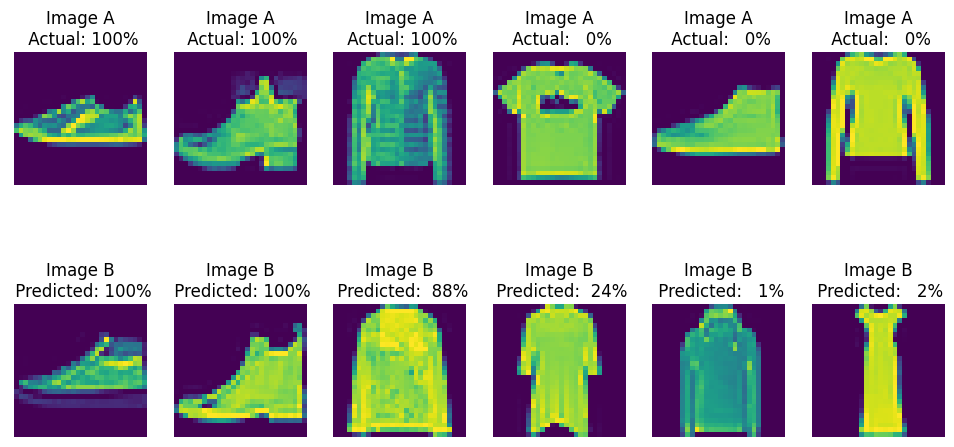

In [90]:

_ = show_model_output()

In [96]:
from sklearn.manifold import TSNE



x_test_features = model.predict(x_test, verbose=True, batch_size=256)

tsne_obj = TSNE(n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=1)
tsne_features = tsne_obj.fit_transform(x_test_features)

40/40 [==============================] - 2s 13ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 4.765s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.840748
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.334839
[t-SNE] KL divergence aft

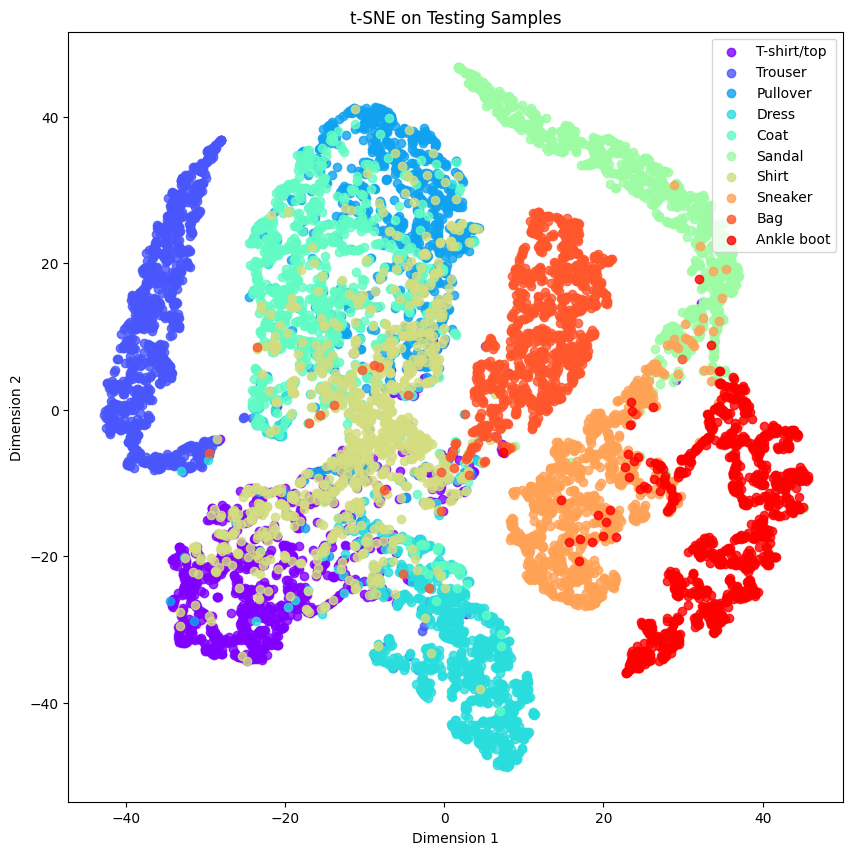

In [97]:

obj_categories = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker="o",
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label,
    )
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("t-SNE on Testing Samples")
plt.legend(loc="best")
plt.show(block=False)
     